In [50]:
import os
import numpy as np
import pandas as pd
from pandas import concat
import readcsv1
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, ConvLSTM2D, GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot 
from sklearn.metrics import mean_squared_error
from keras.models import load_model
import sklearn.linear_model



USE_all_series =True

if USE_all_series:
    ts = readcsv1.get_data(start='2000-01-01', end='2020-12-31', method='ffill',
     init='bfill', file='file_names.txt', verbose=True)

    
else:
    file_USDEUR = 'Data/USDEUR.csv'
    file_USICSAM = 'Data/USICSAM.csv'
    file_EZ_CI = 'Data/Euro Area Consumer Confidence Index.csv'
    file_german9year = 'Bond-Germany9-yearNoteYield(IGDEU9D).csv'

    time_series_USICSAM = pd.read_csv(file_USICSAM, sep=',', header=2, index_col=0, parse_dates=['Date'])
    time_series_USDEUR = pd.read_csv(file_USDEUR, sep=',', header=2, index_col=0, parse_dates=['Date'])
    time_series_EZ_CI = pd.read_csv(file_EZ_CI, sep=',', header=2, index_col=0, parse_dates=['Date'])

    #we have to first pad missing values and then select dates otherwise dimensions don't match due to low frequency
    time_series_USICSAM = time_series_USICSAM['Close'].resample('D').pad()['2001-01-01':'2020-12-31']  
    time_series_USDEUR = time_series_USDEUR['Close'].resample('D').pad()['2001-01-01':'2020-12-31']
    time_series_EZ_CI = time_series_EZ_CI['Close'].resample('D').pad()['2001-01-01':'2020-12-31']


    print(type(time_series_EZ_CI))
    print('Unemployment claims: \n', time_series_USICSAM)
    print('\n Exchange rate: \n', time_series_USDEUR)
    print('\n Eurozone Consumer Index: \n', time_series_EZ_CI)
    
    #concatenate values (i.e. w/o date) of series into a single array
    print(np.shape(time_series_USICSAM.values))
    ts = np.transpose(np.vstack((time_series_USDEUR.values, time_series_USICSAM.values, time_series_EZ_CI.values )))
    print(np.shape(ts))






0 Data/000-EuroPerDollar(USDEUR).csv Close
1 Data/000-EuroPerDollar(USDEUR).csv Open
2 Data/000-EuroPerDollar(USDEUR).csv High
3 Data/000-EuroPerDollar(USDEUR).csv Low
4 Data/Bond-Germany2-yearNoteYield(IGDEU2D).csv Close
5 Data/Bond-Germany9-yearNoteYield(IGDEU9D).csv Close
6 Data/Bond-MoodyBAA(MOCBAAD).csv Close
7 Data/Bond-US10-yearBondYield(IGUSA10D).csv Close
8 Data/Bond-US2-yearNoteYield(IGUSA2D).csv Close
9 Data/Commod-GoldPrice(__XAU_D).csv Close
10 Data/Commod-GoldPrice(__XAU_D).csv Open
11 Data/Commod-GoldPrice(__XAU_D).csv High
12 Data/Commod-GoldPrice(__XAU_D).csv Low
13 Data/Commod-OilPrice(__WTC_D).csv Close
14 Data/Commod-OilPrice(__WTC_D).csv Open
15 Data/Commod-OilPrice(__WTC_D).csv High
16 Data/Commod-OilPrice(__WTC_D).csv Low
17 Data/Commod-ReutersCRBIndex(_TRCCRBD).csv Close
18 Data/Commod-ReutersCRBIndex(_TRCCRBD).csv Open
19 Data/Commod-ReutersCRBIndex(_TRCCRBD).csv High
20 Data/Commod-ReutersCRBIndex(_TRCCRBD).csv Low
21 Data/Commod-ReutersCRBIndustrialRaw(CMCRBI

number of time steps used is 7671 , and the number of time-series used is 7


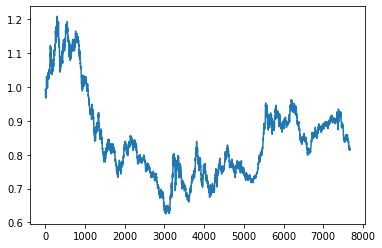

In [51]:
## indicators to use when training
keeplist = [0, 1, 5, 15, 16, 25, 27]
ts = ts[:, keeplist]
no_steps, no_series = ts.shape
print('number of time steps used is %d , and the number of time-series used is %d' %(no_steps, no_series)    )

    
## plot exchange rate
pyplot.plot(ts[:,0])
pyplot.show()

In [52]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = [],[]
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


def delete_multiple_elements(list_object, indices):
    #indices = sorted(indices, reverse=True)
    for idx in indices:
        if idx < len(list_object):
            list_object.pop(idx)
            
            

no_hist_days = 30
# list future days to predict
pred_days = np.arange(1, 31, 3) 
print(pred_days)
# what is the furtherest day of prediction
last_pred_day = max(pred_days) 
# how many days are predicted
num_pred_days = len(pred_days)                    


# don't predict for all time-series
list_cols_dropped = [*range(no_hist_days*no_series, (no_hist_days+last_pred_day)*no_series, 1)] 
# predict for exchange rate on the days of pred_days
keep_cols = [(last_pred_day+1-element) * (-no_series) for element in pred_days]   
print(keep_cols)
delete_multiple_elements( list_cols_dropped, keep_cols )
#print('we need to drop the columns: ', list_cols_dropped)

    
    
# ensure all data is float
ts = ts.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(ts)
print('the normalization is ', scaler.scale_[0] )
# frame as supervised learning. The input numbers are history-days and forecast-days
reframed = series_to_supervised(scaled, no_hist_days, last_pred_day)
# drop columns we don't want to predict, i.e. future steps for all time-series except for exchange rate
reframed.drop(reframed.columns[list_cols_dropped], axis=1, inplace=True)
print(reframed.head())    
    

[ 1  4  7 10 13 16 19 22 25 28]
[-196, -175, -154, -133, -112, -91, -70, -49, -28, -7]
    var1(t-30)  var2(t-30)  var3(t-30)  var4(t-30)  var5(t-30)  var6(t-30)  \
30    0.629794    0.627159    0.948485    0.123534    0.123534    0.047054   
31    0.629794    0.627159    0.948485    0.123534    0.123534    0.047054   
32    0.598117    0.632632    0.957576    0.123534    0.123534    0.047054   
33    0.590582    0.601163    0.980303    0.122067    0.122067    0.047054   
34    0.589726    0.592440    0.975758    0.115396    0.115396    0.047054   

    var7(t-30)  var1(t-29)  var2(t-29)  var3(t-29)  ...   var1(t)  var1(t+3)  \
30    0.608408    0.629794    0.627159    0.948485  ...  0.696062   0.659075   
31    0.608408    0.598117    0.632632    0.957576  ...  0.690925   0.672260   
32    0.597944    0.590582    0.601163    0.980303  ...  0.683562   0.672260   
33    0.585827    0.589726    0.592440    0.975758  ...  0.659075   0.672260   
34    0.586194    0.588870    0.588165    0.

In [53]:
values = reframed.values
#print(values)

# split into train, val and test sets
values = reframed.values
n_train_days = 365 * 12
n_val_days = 235 * 4
train = values[:n_train_days, :]
val = values[n_train_days:n_train_days+n_val_days, :]
test = values[n_train_days+n_val_days:, :]

# split into input and outputs
train_X, train_y = train[:, :-num_pred_days], train[:, -num_pred_days:]
val_X, val_y = train[:, :-num_pred_days], train[:, -num_pred_days:]
test_X, test_y = test[:, :-num_pred_days], test[:, -num_pred_days:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], no_hist_days, no_series))
val_X = val_X.reshape((val_X.shape[0], no_hist_days, no_series))
test_X = test_X.reshape((test_X.shape[0], no_hist_days, no_series))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_X)
print(train_y)

(4380, 30, 7) (4380, 10) (2294, 30, 7) (2294, 10)
[[[0.6297945  0.62715924 0.9484849  ... 0.12353373 0.04705381 0.60840833]
  [0.6297945  0.62715924 0.9484849  ... 0.12353373 0.04705381 0.60840833]
  [0.5981165  0.63263214 0.9575758  ... 0.12353373 0.04705381 0.5979439 ]
  ...
  [0.68664396 0.662904   0.9969697  ... 0.13460413 0.04705381 0.62750137]
  [0.68664396 0.662904   0.9969697  ... 0.13460413 0.04705381 0.62750137]
  [0.68664396 0.662904   0.9969697  ... 0.13460413 0.04705381 0.62750137]]

 [[0.6297945  0.62715924 0.9484849  ... 0.12353373 0.04705381 0.60840833]
  [0.5981165  0.63263214 0.9575758  ... 0.12353373 0.04705381 0.5979439 ]
  [0.59058225 0.6011629  0.98030305 ... 0.12206746 0.04705381 0.58582723]
  ...
  [0.68664396 0.662904   0.9969697  ... 0.13460413 0.04705381 0.62750137]
  [0.68664396 0.662904   0.9969697  ... 0.13460413 0.04705381 0.62750137]
  [0.69606173 0.6801778  0.99242425 ... 0.13739005 0.05726194 0.6432899 ]]

 [[0.5981165  0.63263214 0.9575758  ... 0.1235

In [54]:
#### Hyperparameters and choices ... yet to be optimized

# step = tf.Variable(0, trainable=False)
# boundaries = [100, 100]
# values = [1e-4, 1e-8, 1e-8]
# learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
#     boundaries, values)
# opt = keras.optimizers.SGD(learning_rate=learning_rate_fn(step))

lr = 1e-3
opt = keras.optimizers.Adam(learning_rate=lr)
ls = 'mse'  # 'mse'
bs = 100
epo = 200
hid_dim1 = 300
do_rate = 0.1
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model_type = 'GRU' # or 'LSTM' or 'ConvLSTM2D'


# design network



if model_type=='LSTM':
    model = Sequential()
    model.add(LSTM(hid_dim1, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(do_rate))
    model.add(LSTM(hid_dim1, return_sequences=True ) )
    model.add(Dropout(do_rate))
    model.add(LSTM(hid_dim1, return_sequences=True ) )
    model.add(Dropout(do_rate))
    model.add(LSTM(hid_dim1)  )
    model.add(Dense(num_pred_days))
    model.compile(loss=ls, optimizer=opt)
elif model_type=='GRU':
    model = Sequential()
    model.add(GRU(100, kernel_regularizer='l1', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(GRU(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(100))
    model.add(Dropout(0.2))
    model.add(Dense(num_pred_days))
    model.compile(optimizer=opt, loss=ls)
elif model_type=='ConvLSTM2D':
    model.add(ConvLSTM2D(hid_dim1, kernel_size=(1,2), input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(hid_dim1, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(300))
    model.add(Dropout(do_rate)) 
    model.add(Dense(1)) 
    
    
model.summary
    

# fit network
history = model.fit(train_X, train_y, epochs=epo, batch_size=bs, validation_data=(val_X, val_y), verbose=2, callbacks=[callback], shuffle=False)

model.save('RNN_model.h5') 




Epoch 1/200


KeyboardInterrupt: 

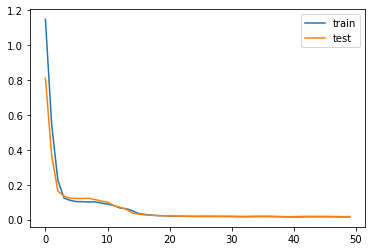

72/72 [==============================] - 2s 10ms/step - loss: 0.0173
0.01729550026357174


In [55]:
RNN_model = load_model('RNN_model.h5')


# plot history for loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

scores = RNN_model.evaluate(test_X, test_y, verbose=1)
print(scores)






In [57]:
# Now compare to Linear Regression model

# 30-day prediction

tsLinRegr = ts[:, 0]
no_steps, lin_no_series = tsLinRegr.shape , 1 

#no_hist_days = 30
# list future days to predict
#pred_days = np.arange(1, 31, 3) 

# what is the furtherest day of prediction
last_pred_day = max(pred_days) 
# how many days are predicted
num_pred_days = len(pred_days)                    


# don't predict for all time-series
list_cols_dropped = [*range(no_hist_days*lin_no_series, (no_hist_days+last_pred_day)*lin_no_series, 1)] 
# predict for exchange rate on the days of pred_days
keep_cols = [(last_pred_day+1-element) * (-lin_no_series) for element in pred_days]   
#print(keep_cols)
delete_multiple_elements( list_cols_dropped, keep_cols )
#print('we need to drop the columns: ', list_cols_dropped)

    
    
# ensure all data is float
tsLinRegr = tsLinRegr.astype('float32')
tsLinRegr = tsLinRegr.reshape(-1, 1)
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(tsLinRegr)
# frame as supervised learning. The input numbers are history-days and forecast-days
reframed = series_to_supervised(scaled, no_hist_days, last_pred_day)
# drop columns we don't want to predict, i.e. future steps for all time-series except for exchange rate
reframed.drop(reframed.columns[list_cols_dropped], axis=1, inplace=True)
#print(reframed.head())    
    
    
values = reframed.values
    
test = values[n_train_days+n_val_days:, :]

# split into input and outputs
lin_test_X, test_y = test[:, :-num_pred_days], test[:, -num_pred_days:]
# reshape input to be 3D [samples, timesteps, features]
lin_test_X = lin_test_X.reshape((lin_test_X.shape[0], no_hist_days, lin_no_series))
print('the shapes of test_X and test_y are ', lin_test_X.shape, test_y.shape)
 

N = lin_test_X.shape[0]
      
learn_window = np.arange(30)
predict_window = np.arange(0, 30, 3)


no_hist_days = 30
pred_days = np.arange(1, 31, 3) 
print('the predicted days are ', pred_days)
# what is the furtherest day of prediction
last_pred_day = np.amax(pred_days)
#print(last_pred_day)






        
stream = []
for i in range(N-no_hist_days-last_pred_day-1):
    
    
    watch_window = lin_test_X[i,:,:]
    #print(watch_window.shape )
    watch_window = watch_window.reshape( (1,no_hist_days,-1) )
    watch_window_plot = lin_test_X[i,:,0]
    actual = test_y[i,:]

      
    lin_mod = sklearn.linear_model.LinearRegression()
    lin_mod.fit(np.arange(no_hist_days).reshape(-1, 1), watch_window_plot)
    lin_pred = lin_mod.predict((no_hist_days+pred_days).reshape(-1, 1) )
    
    mse_lin = np.mean(np.square(lin_pred - actual))

#     scale_factor = 1/scaler.scale_[0] # bring back to original scale
#     mse *= scale_factor
    ## ==================================================
        
    stream.append(mse_lin)
            
print("%.3e" % np.mean(stream))

the shapes of test_X and test_y are  (2294, 30, 1) (2294, 10)
the predicted days are  [ 1  4  7 10 13 16 19 22 25 28]
1.266e-03


(2294, 30, 7)
(30, 7)


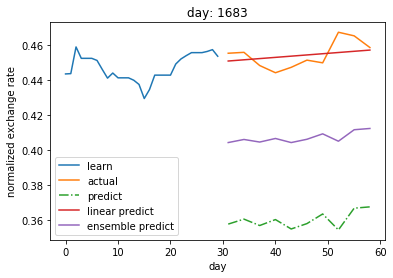

MSE of RNN: 8.931e-03
MSE of Linear Regression: 4.209e-05
(30, 7)


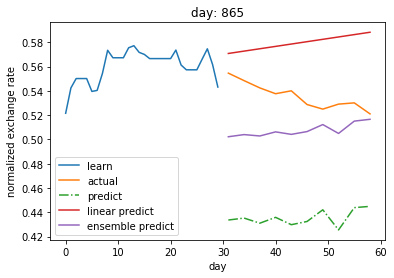

MSE of RNN: 1.025e-02
MSE of Linear Regression: 2.163e-03
(30, 7)


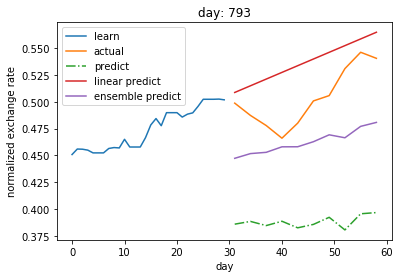

MSE of RNN: 1.389e-02
MSE of Linear Regression: 1.374e-03
(30, 7)


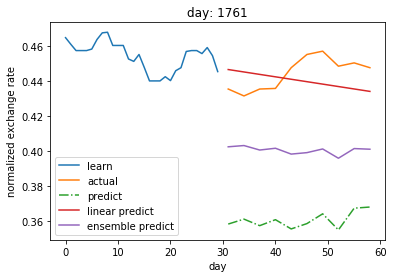

MSE of RNN: 7.071e-03
MSE of Linear Regression: 1.598e-04
(30, 7)


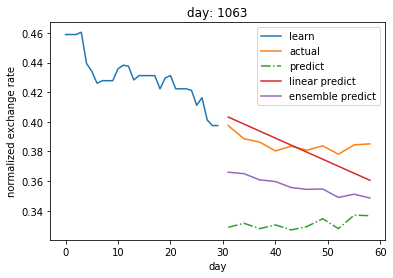

MSE of RNN: 2.928e-03
MSE of Linear Regression: 1.383e-04
(30, 7)


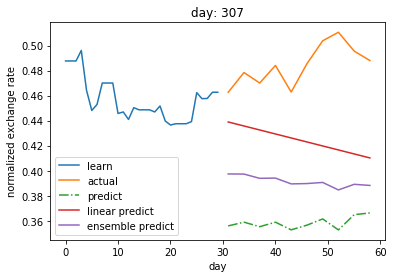

MSE of RNN: 1.605e-02
MSE of Linear Regression: 4.076e-03
(30, 7)


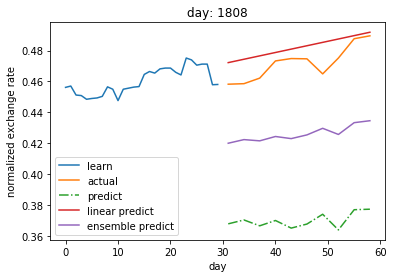

MSE of RNN: 1.048e-02
MSE of Linear Regression: 1.370e-04
(30, 7)


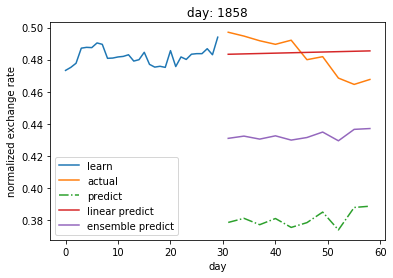

MSE of RNN: 1.064e-02
MSE of Linear Regression: 1.513e-04
(30, 7)


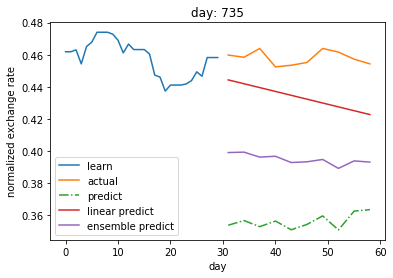

MSE of RNN: 1.041e-02
MSE of Linear Regression: 6.554e-04
(30, 7)


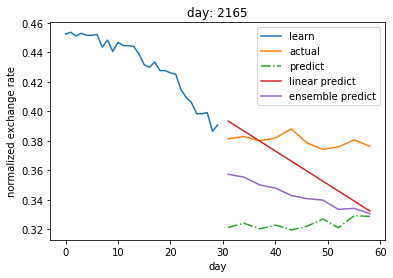

MSE of RNN: 3.215e-03
MSE of Linear Regression: 6.076e-04
(30, 7)


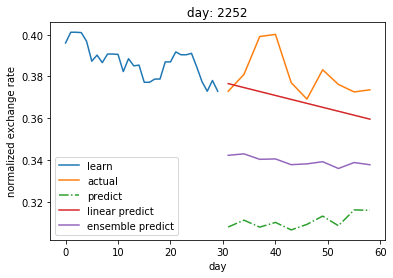

MSE of RNN: 5.015e-03
MSE of Linear Regression: 2.481e-04
(30, 7)


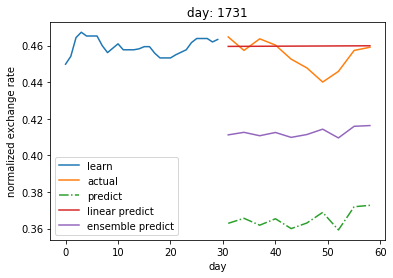

MSE of RNN: 8.132e-03
MSE of Linear Regression: 8.321e-05
(30, 7)


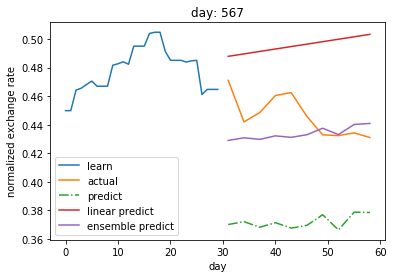

MSE of RNN: 5.773e-03
MSE of Linear Regression: 2.766e-03
(30, 7)


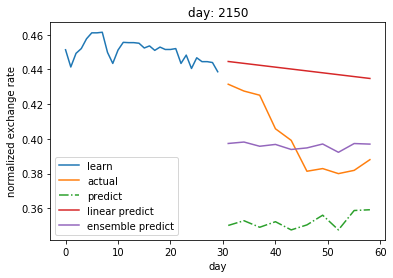

MSE of RNN: 2.765e-03
MSE of Linear Regression: 1.844e-03
(30, 7)


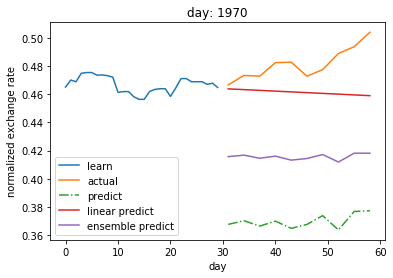

MSE of RNN: 1.255e-02
MSE of Linear Regression: 5.510e-04
(30, 7)


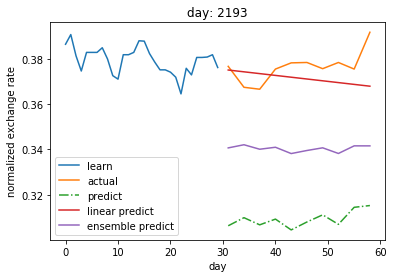

MSE of RNN: 4.554e-03
MSE of Linear Regression: 9.196e-05
(30, 7)


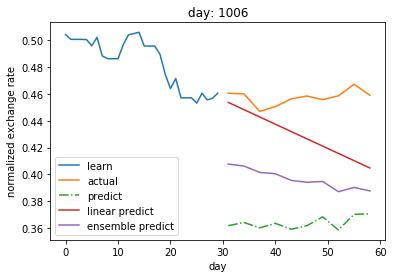

MSE of RNN: 8.736e-03
MSE of Linear Regression: 1.117e-03
(30, 7)


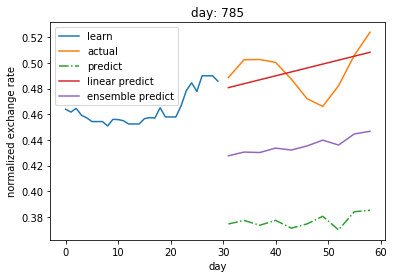

MSE of RNN: 1.373e-02
MSE of Linear Regression: 3.094e-04
(30, 7)


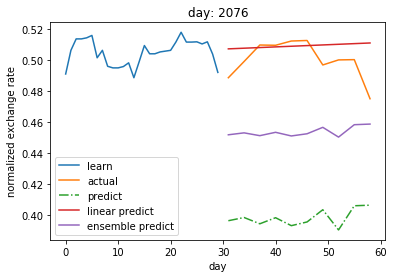

MSE of RNN: 1.061e-02
MSE of Linear Regression: 2.107e-04
(30, 7)


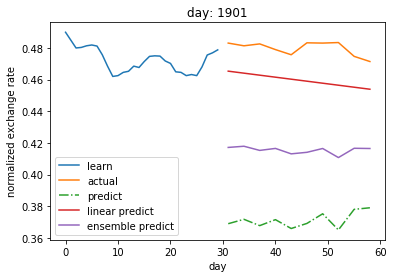

MSE of RNN: 1.183e-02
MSE of Linear Regression: 4.187e-04
(30, 7)


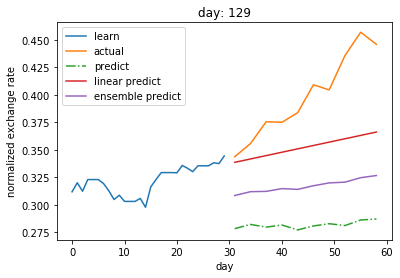

MSE of RNN: 1.484e-02
MSE of Linear Regression: 2.915e-03
(30, 7)


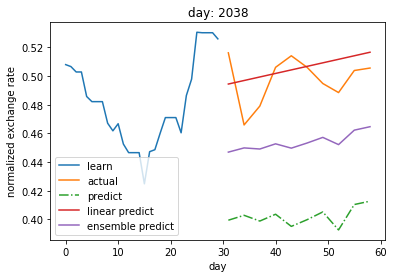

MSE of RNN: 9.475e-03
MSE of Linear Regression: 2.941e-04
(30, 7)


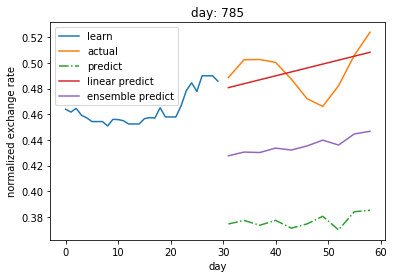

MSE of RNN: 1.373e-02
MSE of Linear Regression: 3.094e-04
(30, 7)


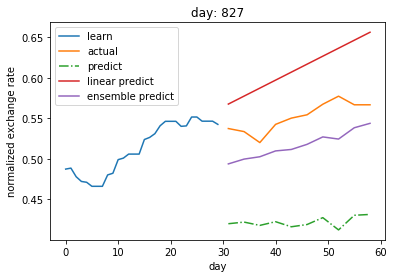

MSE of RNN: 1.709e-02
MSE of Linear Regression: 3.877e-03
(30, 7)


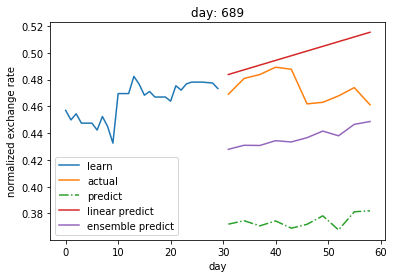

MSE of RNN: 1.009e-02
MSE of Linear Regression: 9.750e-04
(30, 7)


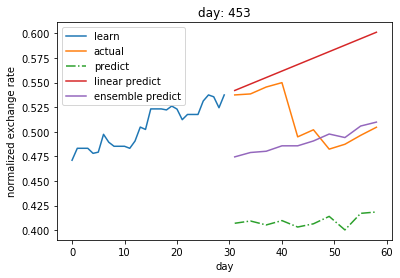

MSE of RNN: 1.167e-02
MSE of Linear Regression: 5.006e-03
(30, 7)


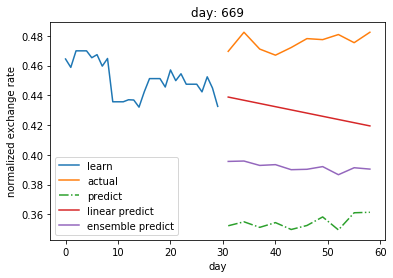

MSE of RNN: 1.469e-02
MSE of Linear Regression: 2.261e-03
(30, 7)


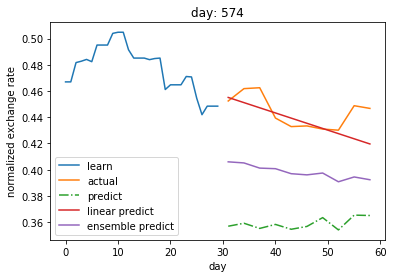

MSE of RNN: 7.367e-03
MSE of Linear Regression: 1.793e-04
(30, 7)


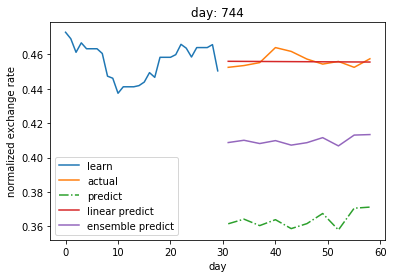

MSE of RNN: 8.611e-03
MSE of Linear Regression: 1.372e-05
(30, 7)


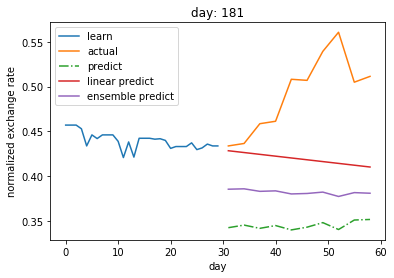

MSE of RNN: 2.337e-02
MSE of Linear Regression: 7.396e-03
(30, 7)


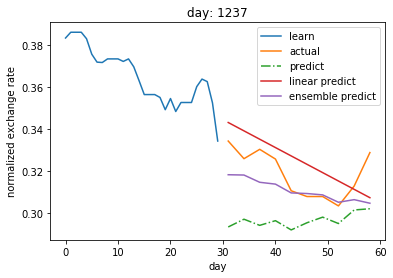

MSE of RNN: 6.169e-04
MSE of Linear Regression: 1.546e-04
(30, 7)


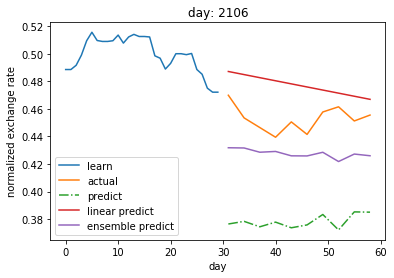

MSE of RNN: 5.641e-03
MSE of Linear Regression: 7.026e-04
(30, 7)


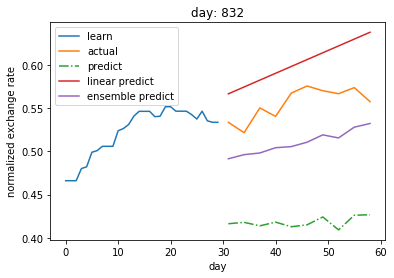

MSE of RNN: 1.923e-02
MSE of Linear Regression: 2.380e-03
(30, 7)


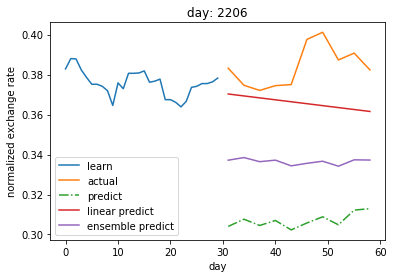

MSE of RNN: 5.993e-03
MSE of Linear Regression: 4.514e-04
(30, 7)


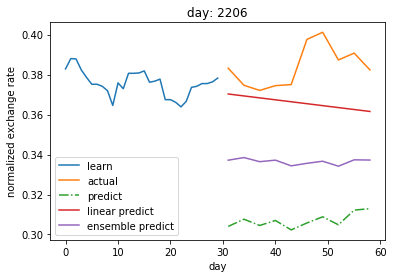

MSE of RNN: 5.993e-03
MSE of Linear Regression: 4.514e-04
(30, 7)


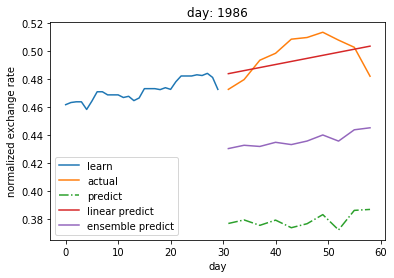

MSE of RNN: 1.419e-02
MSE of Linear Regression: 1.553e-04
(30, 7)


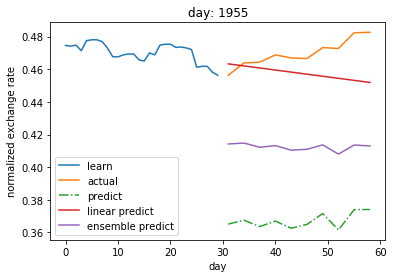

MSE of RNN: 1.057e-02
MSE of Linear Regression: 2.758e-04
(30, 7)


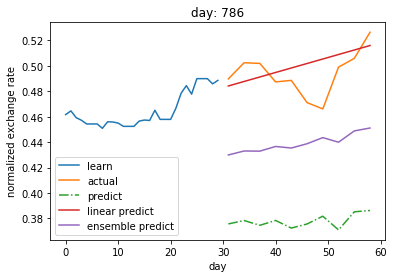

MSE of RNN: 1.367e-02
MSE of Linear Regression: 3.247e-04
(30, 7)


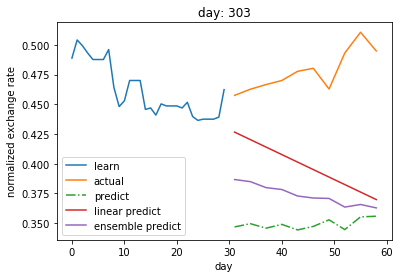

MSE of RNN: 1.674e-02
MSE of Linear Regression: 7.393e-03
(30, 7)


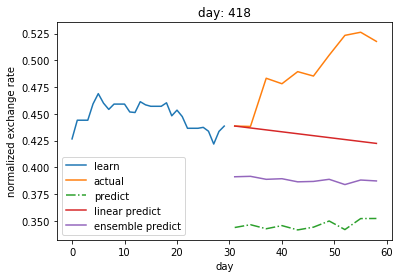

MSE of RNN: 2.112e-02
MSE of Linear Regression: 4.572e-03
(30, 7)


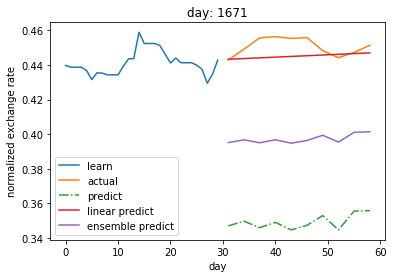

MSE of RNN: 1.033e-02
MSE of Linear Regression: 5.517e-05
(30, 7)


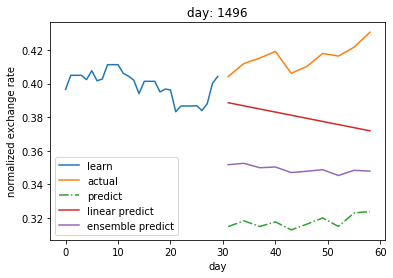

MSE of RNN: 9.604e-03
MSE of Linear Regression: 1.378e-03
(30, 7)


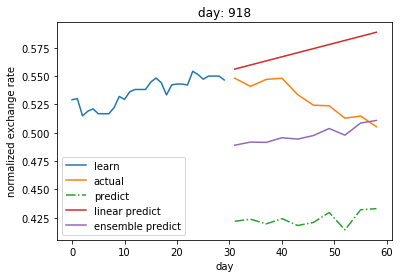

MSE of RNN: 1.160e-02
MSE of Linear Regression: 2.445e-03
(30, 7)


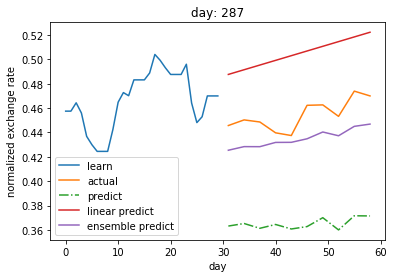

MSE of RNN: 8.065e-03
MSE of Linear Regression: 2.628e-03
(30, 7)


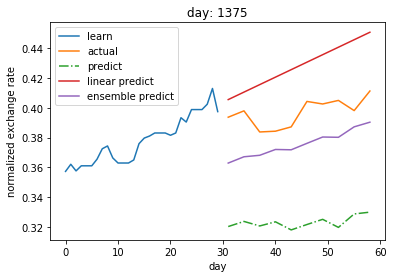

MSE of RNN: 5.515e-03
MSE of Linear Regression: 1.104e-03
(30, 7)


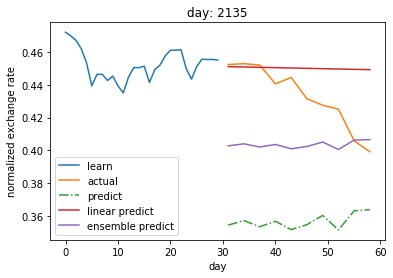

MSE of RNN: 6.306e-03
MSE of Linear Regression: 5.996e-04
(30, 7)


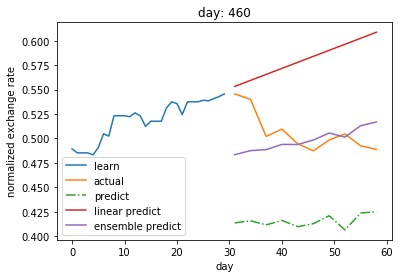

MSE of RNN: 8.696e-03
MSE of Linear Regression: 6.793e-03
(30, 7)


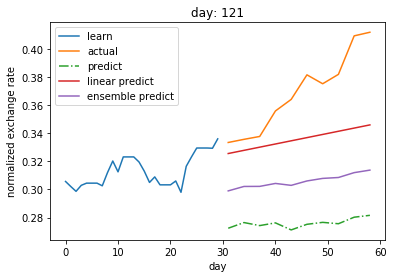

MSE of RNN: 9.215e-03
MSE of Linear Regression: 1.519e-03
(30, 7)


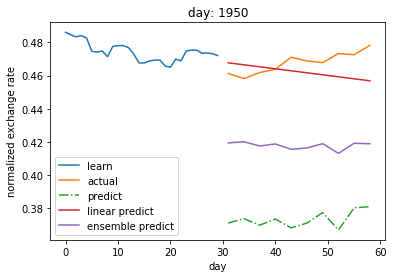

MSE of RNN: 8.939e-03
MSE of Linear Regression: 1.156e-04
(30, 7)


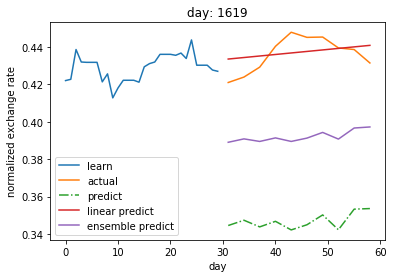

MSE of RNN: 8.088e-03
MSE of Linear Regression: 6.390e-05


In [60]:
import sklearn.linear_model

print(test_X.shape)

np.random.seed(0)
for i in np.random.randint(no_hist_days, test_X.shape[0]-31, size=50):
    watch_window = test_X[i,:,:]
    print(watch_window.shape )
    watch_window = watch_window.reshape( (1,no_hist_days,-1) )
    watch_window_plot = test_X[i,:,0]
    actual = test_y[i,:]
    prediction = RNN_model.predict(watch_window)
    prediction = prediction.reshape( (num_pred_days,) )
    
    lin_mod = sklearn.linear_model.LinearRegression()
    lin_mod.fit(np.arange(no_hist_days).reshape(-1, 1), watch_window_plot)
    lin_pred = lin_mod.predict((no_hist_days+pred_days).reshape(-1, 1) )
    
    ensemble_learn = np.mean([prediction, lin_pred], axis=0)
    
    lin_mod_wo_interc = sklearn.linear_model.LinearRegression(fit_intercept=False)
    lin_mod_wo_interc.fit(np.arange(1-no_hist_days,1,+1).reshape(-1, 1), watch_window_plot)
    lin_pred_wo_interc = lin_mod_wo_interc.predict( pred_days.reshape(-1, 1) )   
    
    pyplot.plot(np.arange(no_hist_days), watch_window_plot, label='learn')
    pyplot.plot(no_hist_days+pred_days , actual, label='actual')    #np.arange(last_pred_day)
    pyplot.plot(no_hist_days+pred_days, prediction, '-.', label='predict')
    pyplot.plot(no_hist_days+pred_days, lin_pred, label='linear predict')
    pyplot.plot(no_hist_days+pred_days, ensemble_learn, label='ensemble predict')
    #pyplot.plot(no_hist_days+pred_days, lin_pred_wo_interc, label='linear predict wo intercept')
    pyplot.title('day: %d' % i)
    pyplot.ylabel('normalized exchange rate')
    pyplot.xlabel('day')
    pyplot.legend()
    pyplot.show()

    mse = np.mean(np.square(prediction - actual))
    mse_lin = np.mean(np.square(lin_pred - actual))
#     scale_factor = 1/scaler.scale_[0]   ## bring back to original scale
#     mse *= scale_factor
    
    print("MSE of RNN: %.3e" % mse)
    print("MSE of Linear Regression: %.3e" % mse_lin)



    
    

# Now let's try a model with first a layer of Fourier transform for denoising and  then stacked layers of LSTM.

/Users/stathismegas/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/stathismegas/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/stathismegas/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/stathismegas/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


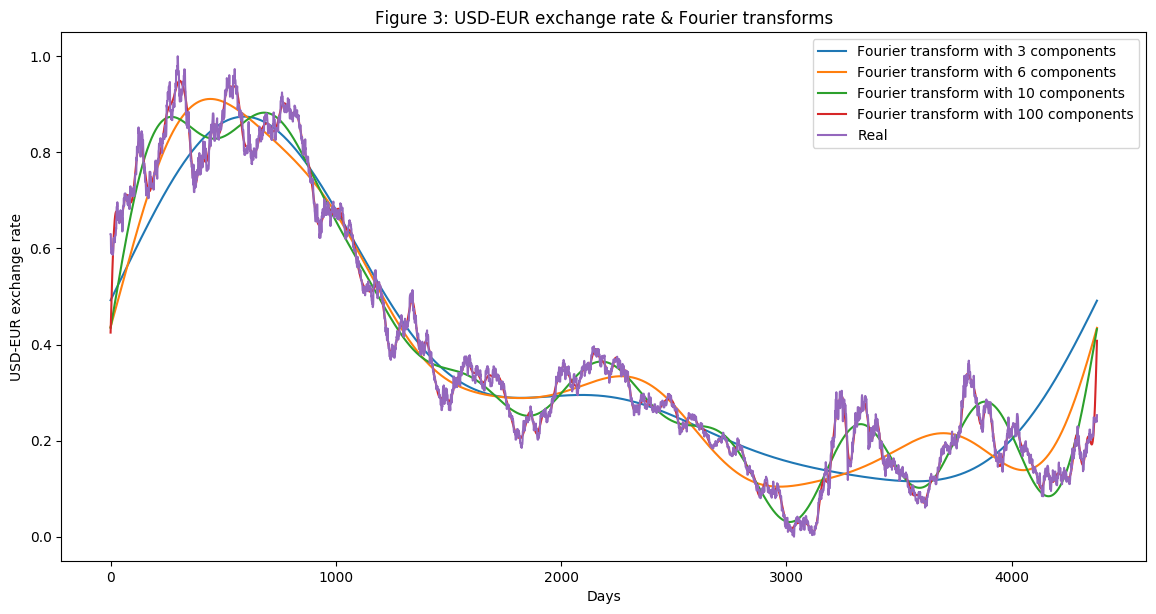

In [9]:
fft_list = np.fft.fft( train_X[:,0,0]   )

## plot exchange rate
pyplot.figure(figsize=(14, 7), dpi=100)

for num_ in [3, 6, 10, 100]:
    fft_list_m10= np.copy(fft_list)
    fft_list_m10[num_:-num_]=0
    #print(fft_list_m10[5])
    pyplot.plot( np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
pyplot.plot(  train_X[:,0,0]  ,  label='Real')
pyplot.xlabel('Days')
pyplot.ylabel('USD-EUR exchange rate')
pyplot.title('Figure 3: USD-EUR exchange rate & Fourier transforms')
pyplot.legend()
pyplot.show()

We will use FT denoising on train_X, but not on train_y during training.

(4380, 30, 7)


/Users/stathismegas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


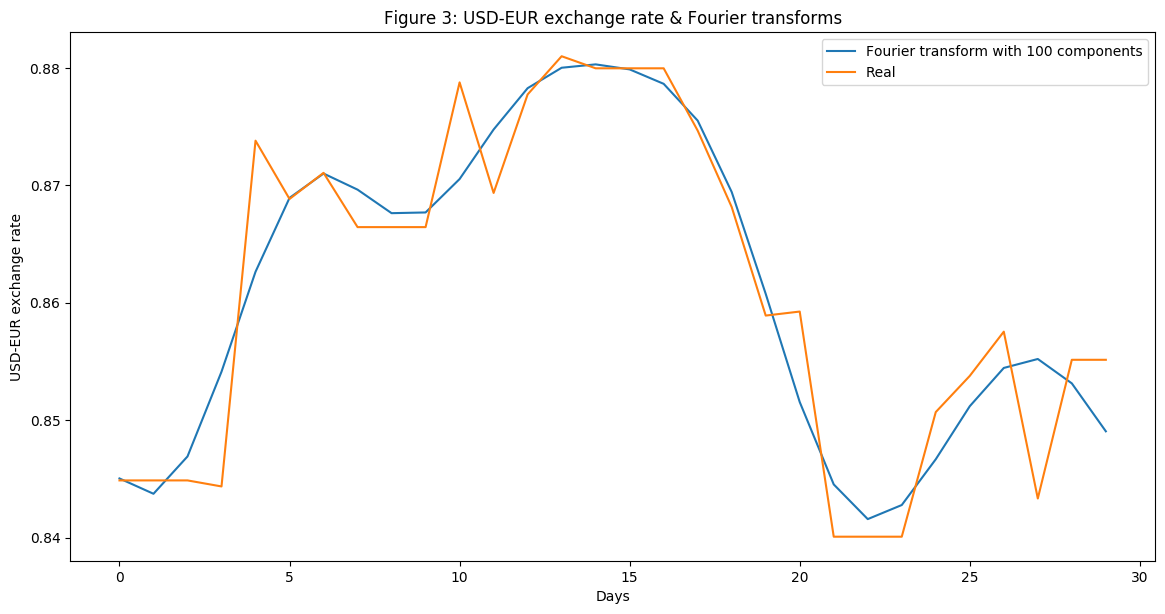

In [10]:
print(train_X.shape)

trunc = 5

train_X_denoised = np.zeros_like(train_X)

for day in range(train_X.shape[0]):
    for feat in range(train_X.shape[2]):
        seq = train_X[day,:,feat]
        seq_fft = np.fft.fft( seq )
        seq_fft[trunc:-trunc]=0
        denoised = np.fft.ifft(seq_fft)
        #print('denoised is ' , denoised) 
        train_X_denoised[day,:,feat] = denoised
        #print('train_X_denoised is ', train_X_denoised[day,:,feat])

    
## plot exchange rate
pyplot.figure(figsize=(14, 7), dpi=100)
pyplot.plot( train_X_denoised[678,:,0], label='Fourier transform with {} components'.format(num_))
pyplot.plot(  train_X[678,:,0]  ,  label='Real')
pyplot.xlabel('Days')
pyplot.ylabel('USD-EUR exchange rate')
pyplot.title('Figure 3: USD-EUR exchange rate & Fourier transforms')
pyplot.legend()
pyplot.show()



In [ ]:
#lr = 5e-3
opt = keras.optimizers.Adam(learning_rate=lr)
ls = 'mse'  # 'mse'
bs = 100
epo = 40
hid_dim1 = 300    # 100 and lr = 1e-3; 200 and 7e-5 do_rate=0.2
do_rate = 0.3
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
model_type = 'GRU' # or 'LSTM' or 'ConvLSTM2D'


lrs =  [1e-2,5e-3,1e-3,5e-4,1e-4,5e-5,1e-5,5e-6,1e-6,5e-7]   #[7e-2] #,5e-5,1e-5, 5e-6]   # [1e-2,5e-3,1e-3,5e-4,1e-4,5e-5]   excellent 5e-5, 1e-5 and hid_dim1 = 400
val_losses = []

best_loss = 1000

for lr in lrs:
    print('trying learning rate ', lr)
    opt = keras.optimizers.Adam(learning_rate=lr)

    # design network
    if model_type=='LSTM':
        denoised_model = Sequential()
#         denoised_model.add(LSTM(hid_dim1, return_sequences=True, input_shape=(train_X_denoised.shape[1], train_X_denoised.shape[2])))
#         denoised_model.add(Dropout(do_rate))
#         denoised_model.add(LSTM(hid_dim1, return_sequences=True ) )
#         denoised_model.add(Dropout(do_rate))
#         denoised_model.add(LSTM(hid_dim1, return_sequences=True ) )
#         denoised_model.add(Dropout(do_rate))
        denoised_model.add(LSTM(hid_dim1)  )
        denoised_model.add(Dropout(do_rate))
        denoised_model.add(Dense(num_pred_days))
        denoised_model.compile(loss=ls, optimizer=opt)
    elif model_type=='GRU':
        denoised_model = Sequential()
        denoised_model.add(GRU(hid_dim1, kernel_regularizer='l1', return_sequences=True, input_shape=(train_X_denoised.shape[1], train_X_denoised.shape[2])))
        denoised_model.add(Dropout(do_rate))
        denoised_model.add(GRU(hid_dim1, return_sequences=True))
        denoised_model.add(Dropout(do_rate))
        denoised_model.add(GRU(hid_dim1))
        denoised_model.add(Dropout(do_rate))
        denoised_model.add(Dense(num_pred_days))
        denoised_model.compile(optimizer=opt, loss=ls)
    elif model_type=='ConvLSTM2D':
        denoised_model.add(ConvLSTM2D(hid_dim1, kernel_size=(1,2), input_shape=(train_X_denoised.shape[1], train_X_denoised.shape[2])))
#        denoised_model.add(LSTM(hid_dim1, input_shape=(train_X_denoised.shape[1], train_X_denoised.shape[2])))
        denoised_model.add(Dense(300))
        denoised_model.add(Dropout(do_rate)) 
        denoised_model.add(Dense(num_pred_days)) 


    #model.summary

    # fit network
    history = denoised_model.fit(train_X_denoised, train_y, epochs=epo, batch_size=bs, validation_data=(val_X, val_y), verbose=2, callbacks=[callback], shuffle=False)
    scores = denoised_model.evaluate(val_X, val_y, verbose=1)
    val_losses.append(scores)
    print(scores)
    print('\n')
    if scores<best_loss:
        best_loss = scores
        best_lr = lr
        best_denoised_model = denoised_model
        best_denoised_model.save('denoised_gru300_300_300.h5') 



print(best_loss)
print(best_lr)
scores = denoised_model.evaluate(test_X, test_y, verbose=1)





trying learning rate  0.01
Epoch 1/40
44/44 - 21s - loss: 2.3918 - val_loss: 1.0889
Epoch 2/40
44/44 - 17s - loss: 0.9025 - val_loss: 0.6061
Epoch 3/40
44/44 - 18s - loss: 0.4844 - val_loss: 0.3754
Epoch 4/40
44/44 - 18s - loss: 0.2650 - val_loss: 0.2485
Epoch 5/40
44/44 - 18s - loss: 0.1570 - val_loss: 0.1977
Epoch 6/40
44/44 - 18s - loss: 0.1178 - val_loss: 0.1771
Epoch 7/40
44/44 - 18s - loss: 0.1033 - val_loss: 0.1689
Epoch 8/40
44/44 - 18s - loss: 0.0994 - val_loss: 0.1645
Epoch 9/40
44/44 - 18s - loss: 0.0966 - val_loss: 0.1653
Epoch 10/40
44/44 - 21s - loss: 0.0977 - val_loss: 0.1686
Epoch 11/40
44/44 - 19s - loss: 0.0963 - val_loss: 0.1658
Epoch 12/40
44/44 - 18s - loss: 0.0971 - val_loss: 0.1659
Epoch 13/40
44/44 - 18s - loss: 0.0967 - val_loss: 0.1725
Epoch 14/40
44/44 - 17s - loss: 0.1006 - val_loss: 0.1740
137/137 [==============================] - 7s 50ms/step - loss: 0.1740
0.17404665052890778


trying learning rate  0.005
Epoch 1/40
44/44 - 24s - loss: 0.8149 - val_loss:

Epoch 12/40
44/44 - 17s - loss: 1.2774 - val_loss: 1.2269
Epoch 13/40
44/44 - 17s - loss: 1.1840 - val_loss: 1.1360
Epoch 14/40
44/44 - 19s - loss: 1.0946 - val_loss: 1.0490
Epoch 15/40
44/44 - 18s - loss: 1.0094 - val_loss: 0.9652
Epoch 16/40
44/44 - 17s - loss: 0.9271 - val_loss: 0.8851
Epoch 17/40
44/44 - 17s - loss: 0.8487 - val_loss: 0.8087
Epoch 18/40
44/44 - 17s - loss: 0.7738 - val_loss: 0.7360
Epoch 19/40
44/44 - 17s - loss: 0.7031 - val_loss: 0.6673
Epoch 20/40
44/44 - 17s - loss: 0.6359 - val_loss: 0.6025
Epoch 21/40
44/44 - 17s - loss: 0.5729 - val_loss: 0.5415
Epoch 22/40
44/44 - 17s - loss: 0.5131 - val_loss: 0.4841
Epoch 23/40
44/44 - 17s - loss: 0.4571 - val_loss: 0.4296
Epoch 24/40
44/44 - 17s - loss: 0.4046 - val_loss: 0.3790
Epoch 25/40
44/44 - 17s - loss: 0.3555 - val_loss: 0.3321
Epoch 26/40
44/44 - 17s - loss: 0.3100 - val_loss: 0.2887
Epoch 27/40
44/44 - 18s - loss: 0.2683 - val_loss: 0.2488
Epoch 28/40
44/44 - 17s - loss: 0.2301 - val_loss: 0.2123
Epoch 29/40
44

In [118]:
best_denoised_model = load_model('denoised_GRU1000.h5')
scores = best_denoised_model.evaluate(val_X, val_y, verbose=1)
scores = best_denoised_model.evaluate(test_X, test_y, verbose=1)
print('the test score is ', scores)



72/72 [==============================] - 3s 47ms/step - loss: 0.0011
the test score is  0.0010615958599373698


[0.01, 0.005, 0.001, 0.0005, 0.0001, 5e-05, 1e-05, 5e-06, 1e-06, 5e-07] ['0.01', '0.005', '0.001', '0.0005', '0.0001', '5e-05', '1e-05', '5e-06', '1e-06', '5e-07']
[0.12663531303405762, 0.1309918612241745, 0.004728212486952543, 0.005043777637183666, 0.0038202195428311825, 0.001991880824789405, 0.0023430564906448126, 0.0020699636079370975, 0.0038971765898168087, 0.015623066574335098]


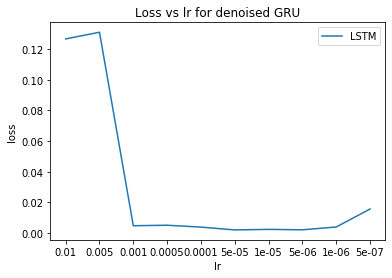

In [112]:
str_lrs = [str(i) for i in lrs]
print(lrs, str_lrs)
print(val_losses)

pyplot.plot(str_lrs, val_losses, label='LSTM')
#pyplot.plot(no_hist_days+pred_days, lin_pred_wo_interc, label='linear predict wo intercept')
pyplot.title('Loss vs lr for denoised GRU')
pyplot.ylabel('loss')
pyplot.xlabel('lr')
pyplot.legend()
pyplot.show()

#val_losses.remove([0.17832733690738678, 0.17592816054821014, 0.17344678938388824, 0.17094436287879944, 0.16844011843204498, 0.1659471094608307, 0.1634698063135147, 0.16101109981536865, 0.1585693210363388, 0.15614554286003113, 0.1537403166294098, 0.15135633945465088, 0.1489880084991455, 0.14663933217525482, 0.14430628716945648, 0.14198943972587585, 0.13968995213508606, 0.13740511238574982, 0.1351371705532074, 0.1328831911087036, 0.13064458966255188, 0.128423810005188, 0.12622188031673431, 0.12402976304292679, 0.1218520775437355, 0.11968971788883209, 0.11754016578197479, 0.11540639400482178, 0.11328563839197159, 0.1111777052283287, 0.10908664017915726, 0.10701001435518265, 0.10494814813137054, 0.10290099680423737, 0.10086805373430252, 0.09885139763355255, 0.09684951603412628, 0.09486514329910278, 0.0928972065448761, 0.09094177186489105, 0.08900696039199829, 0.0870920866727829, 0.08519341796636581, 0.08331449329853058, 0.08145293593406677, 0.07961438596248627, 0.07779057323932648, 0.07598754018545151, 0.07420701533555984, 0.07244815677404404])


# # val_losses_new = [val_losses[i] for i in ]
# print(lrs, len(val_losses) )



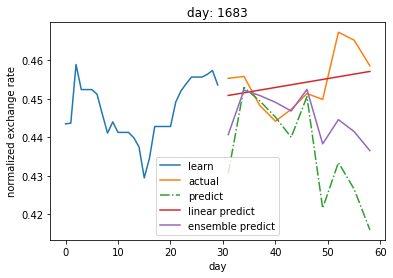

MSE of RNN: 5.938e-04
MSE of Linear Regression: 4.209e-05
MSE of Ensemble: 1.957e-04


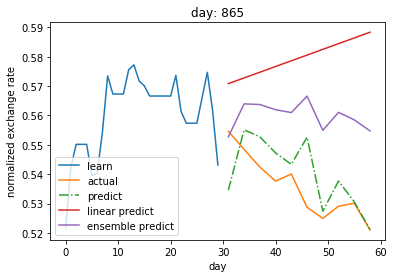

MSE of RNN: 1.301e-04
MSE of Linear Regression: 2.163e-03
MSE of Ensemble: 7.007e-04


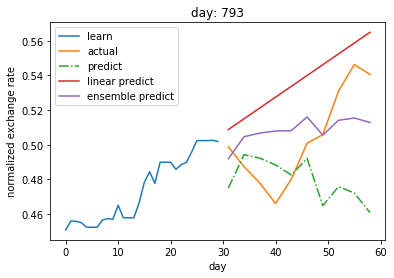

MSE of RNN: 1.796e-03
MSE of Linear Regression: 1.374e-03
MSE of Ensemble: 5.944e-04


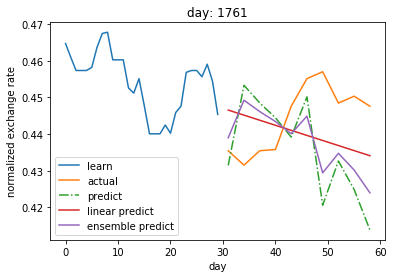

MSE of RNN: 4.203e-04
MSE of Linear Regression: 1.598e-04
MSE of Ensemble: 2.578e-04


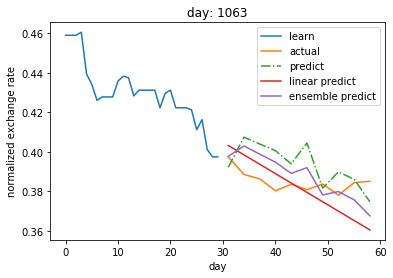

MSE of RNN: 2.025e-04
MSE of Linear Regression: 1.383e-04
MSE of Ensemble: 1.145e-04


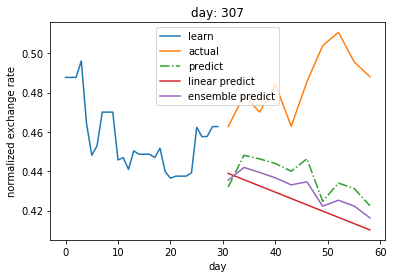

MSE of RNN: 2.665e-03
MSE of Linear Regression: 4.076e-03
MSE of Ensemble: 3.317e-03


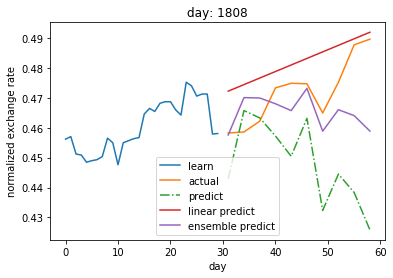

MSE of RNN: 9.762e-04
MSE of Linear Regression: 1.370e-04
MSE of Ensemble: 1.929e-04


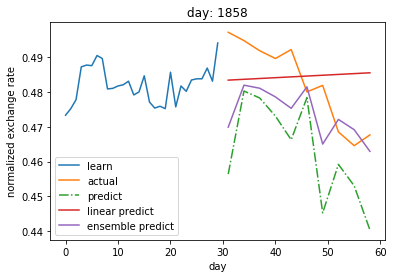

MSE of RNN: 5.293e-04
MSE of Linear Regression: 1.513e-04
MSE of Ensemble: 1.767e-04


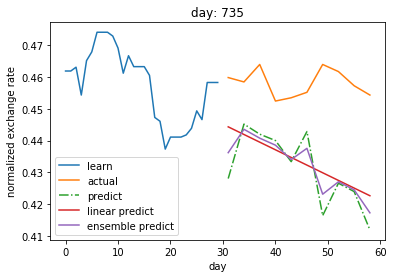

MSE of RNN: 8.724e-04
MSE of Linear Regression: 6.554e-04
MSE of Ensemble: 7.465e-04


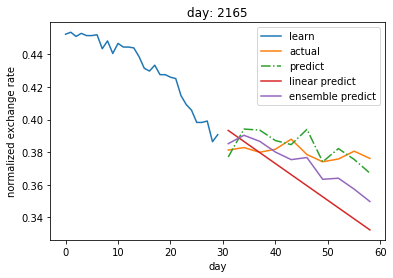

MSE of RNN: 7.575e-05
MSE of Linear Regression: 6.076e-04
MSE of Ensemble: 1.776e-04


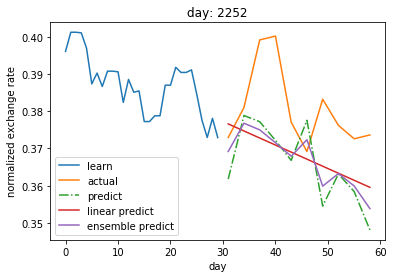

MSE of RNN: 3.412e-04
MSE of Linear Regression: 2.481e-04
MSE of Ensemble: 2.790e-04


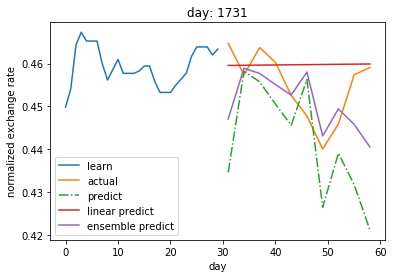

MSE of RNN: 3.511e-04
MSE of Linear Regression: 8.321e-05
MSE of Ensemble: 9.805e-05


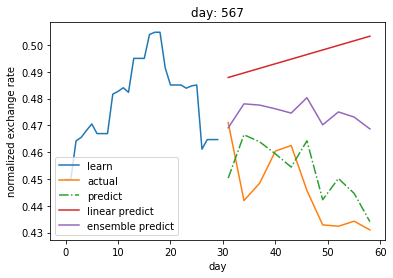

MSE of RNN: 2.202e-04
MSE of Linear Regression: 2.766e-03
MSE of Ensemble: 9.900e-04


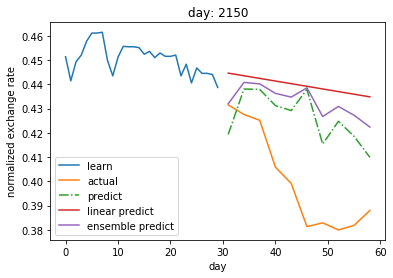

MSE of RNN: 1.005e-03
MSE of Linear Regression: 1.844e-03
MSE of Ensemble: 1.362e-03


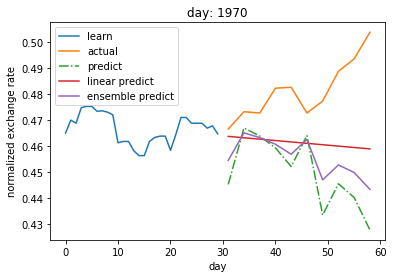

MSE of RNN: 1.460e-03
MSE of Linear Regression: 5.510e-04
MSE of Ensemble: 9.367e-04


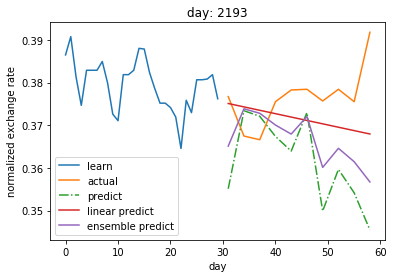

MSE of RNN: 4.446e-04
MSE of Linear Regression: 9.196e-05
MSE of Ensemble: 2.251e-04


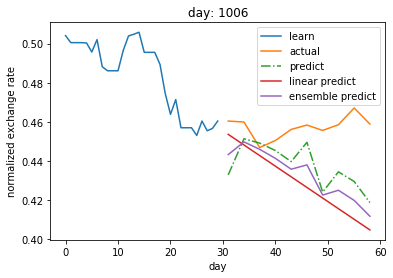

MSE of RNN: 5.804e-04
MSE of Linear Regression: 1.117e-03
MSE of Ensemble: 7.973e-04


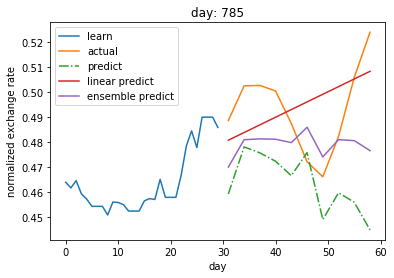

MSE of RNN: 1.293e-03
MSE of Linear Regression: 3.094e-04
MSE of Ensemble: 4.820e-04


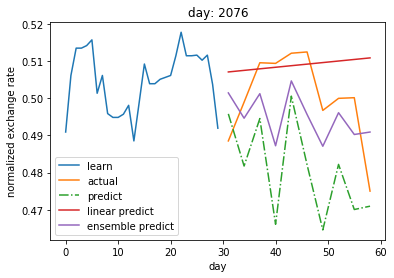

MSE of RNN: 5.788e-04
MSE of Linear Regression: 2.107e-04
MSE of Ensemble: 1.547e-04


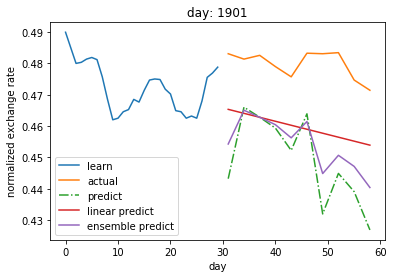

MSE of RNN: 1.086e-03
MSE of Linear Regression: 4.187e-04
MSE of Ensemble: 6.929e-04


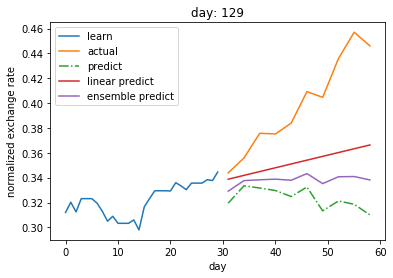

MSE of RNN: 7.363e-03
MSE of Linear Regression: 2.915e-03
MSE of Ensemble: 4.871e-03


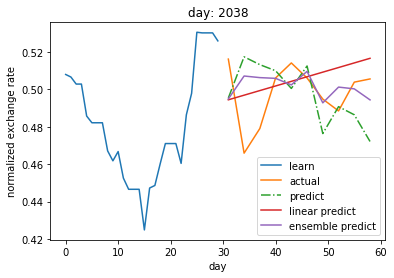

MSE of RNN: 6.275e-04
MSE of Linear Regression: 2.941e-04
MSE of Ensemble: 3.358e-04


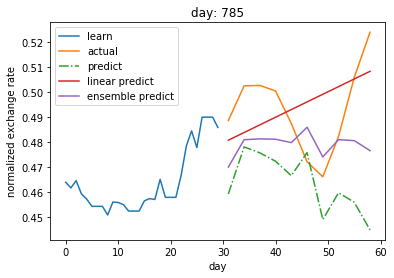

MSE of RNN: 1.293e-03
MSE of Linear Regression: 3.094e-04
MSE of Ensemble: 4.820e-04


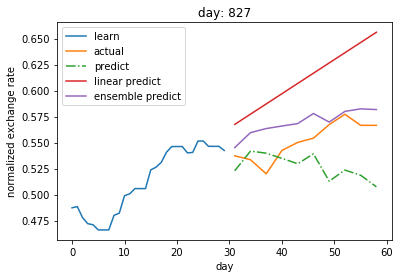

MSE of RNN: 1.300e-03
MSE of Linear Regression: 3.877e-03
MSE of Ensemble: 4.563e-04


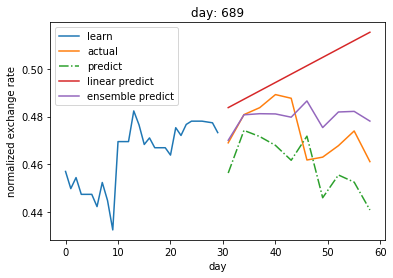

MSE of RNN: 2.885e-04
MSE of Linear Regression: 9.750e-04
MSE of Ensemble: 1.456e-04


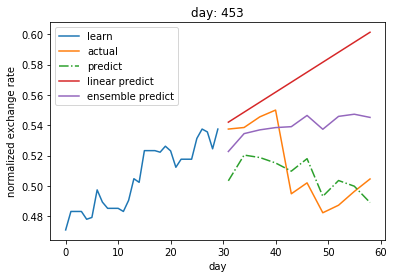

MSE of RNN: 4.537e-04
MSE of Linear Regression: 5.006e-03
MSE of Ensemble: 1.505e-03


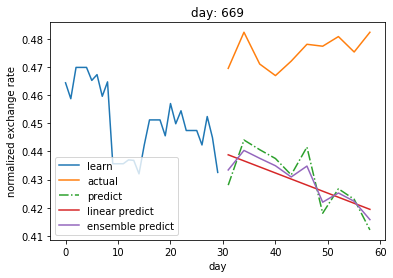

MSE of RNN: 2.209e-03
MSE of Linear Regression: 2.261e-03
MSE of Ensemble: 2.221e-03


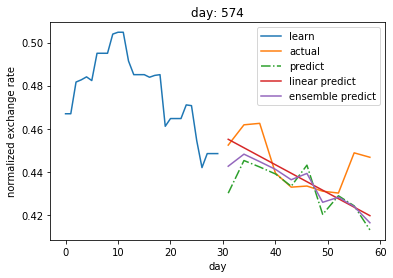

MSE of RNN: 3.138e-04
MSE of Linear Regression: 1.793e-04
MSE of Ensemble: 2.223e-04


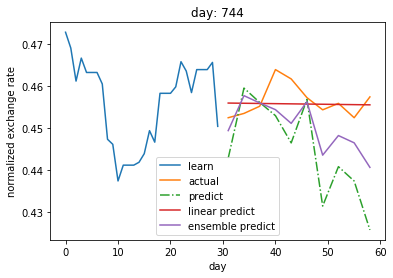

MSE of RNN: 2.470e-04
MSE of Linear Regression: 1.372e-05
MSE of Ensemble: 7.258e-05


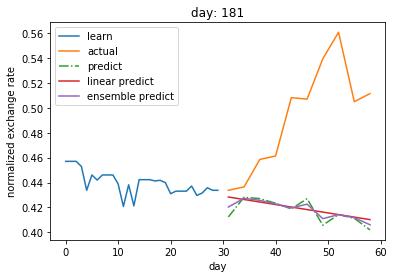

MSE of RNN: 7.752e-03
MSE of Linear Regression: 7.396e-03
MSE of Ensemble: 7.561e-03


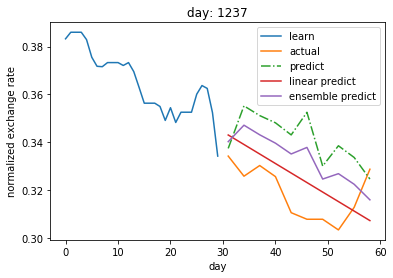

MSE of RNN: 7.039e-04
MSE of Linear Regression: 1.546e-04
MSE of Ensemble: 3.439e-04


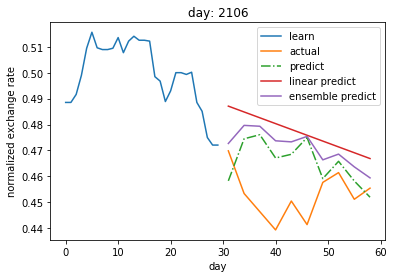

MSE of RNN: 3.761e-04
MSE of Linear Regression: 7.026e-04
MSE of Ensemble: 4.937e-04


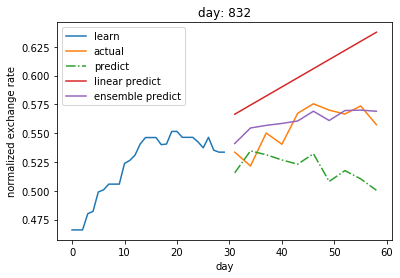

MSE of RNN: 1.834e-03
MSE of Linear Regression: 2.380e-03
MSE of Ensemble: 1.837e-04


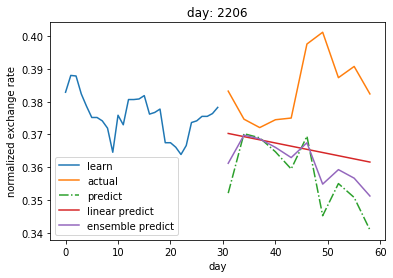

MSE of RNN: 9.638e-04
MSE of Linear Regression: 4.514e-04
MSE of Ensemble: 6.722e-04


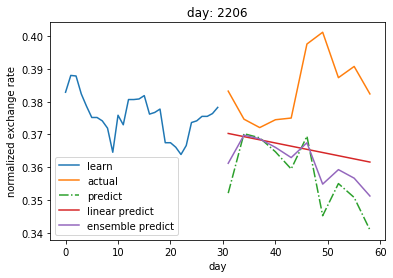

MSE of RNN: 9.638e-04
MSE of Linear Regression: 4.514e-04
MSE of Ensemble: 6.722e-04


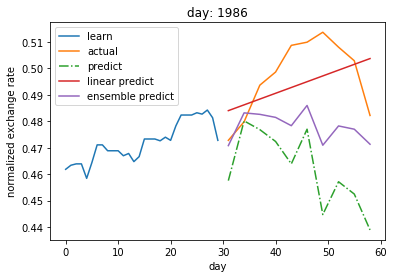

MSE of RNN: 1.609e-03
MSE of Linear Regression: 1.553e-04
MSE of Ensemble: 5.439e-04


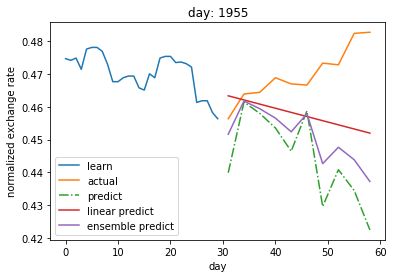

MSE of RNN: 9.898e-04
MSE of Linear Regression: 2.758e-04
MSE of Ensemble: 5.620e-04


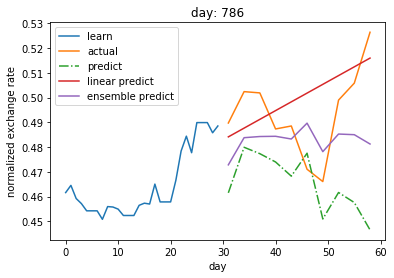

MSE of RNN: 1.284e-03
MSE of Linear Regression: 3.247e-04
MSE of Ensemble: 4.125e-04


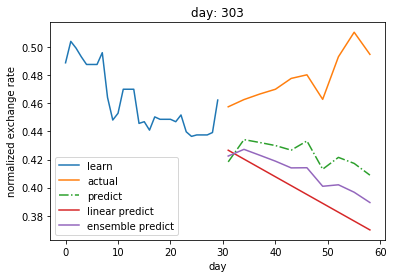

MSE of RNN: 3.370e-03
MSE of Linear Regression: 7.393e-03
MSE of Ensemble: 5.169e-03


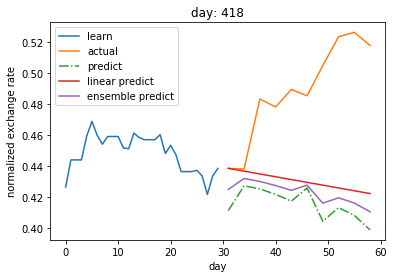

MSE of RNN: 6.621e-03
MSE of Linear Regression: 4.572e-03
MSE of Ensemble: 5.528e-03


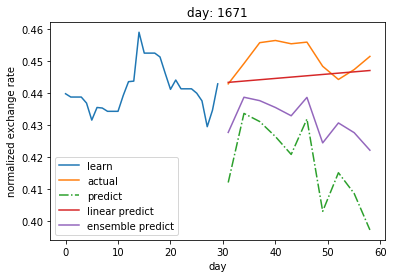

MSE of RNN: 1.177e-03
MSE of Linear Regression: 5.517e-05
MSE of Ensemble: 3.901e-04


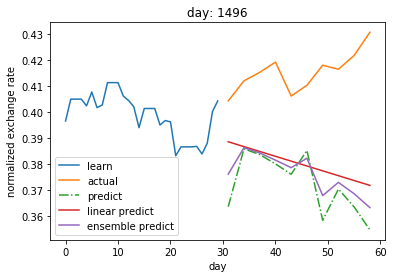

MSE of RNN: 2.120e-03
MSE of Linear Regression: 1.378e-03
MSE of Ensemble: 1.712e-03


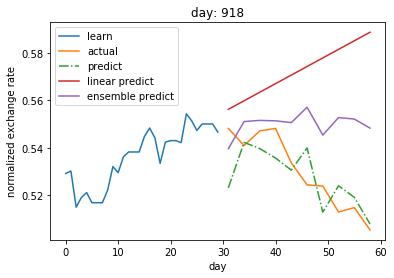

MSE of RNN: 1.363e-04
MSE of Linear Regression: 2.445e-03
MSE of Ensemble: 6.857e-04


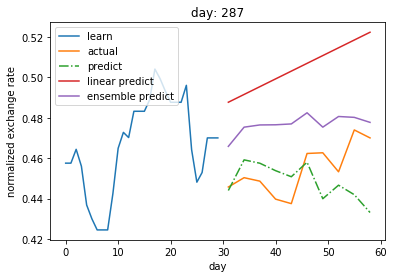

MSE of RNN: 3.506e-04
MSE of Linear Regression: 2.628e-03
MSE of Ensemble: 6.129e-04


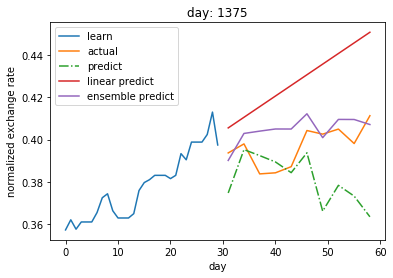

MSE of RNN: 5.545e-04
MSE of Linear Regression: 1.104e-03
MSE of Ensemble: 1.431e-04


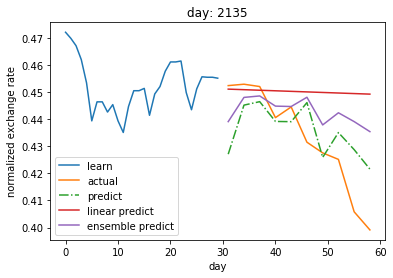

MSE of RNN: 2.106e-04
MSE of Linear Regression: 5.996e-04
MSE of Ensemble: 3.332e-04


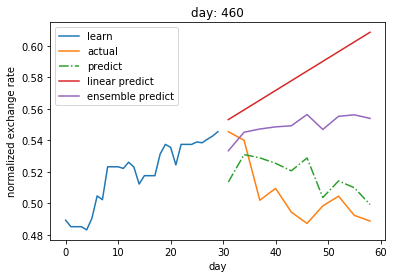

MSE of RNN: 5.030e-04
MSE of Linear Regression: 6.793e-03
MSE of Ensemble: 2.476e-03


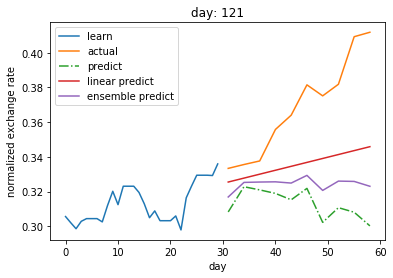

MSE of RNN: 4.139e-03
MSE of Linear Regression: 1.519e-03
MSE of Ensemble: 2.659e-03


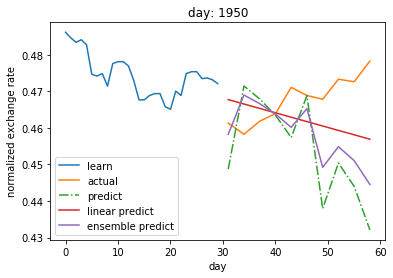

MSE of RNN: 4.929e-04
MSE of Linear Regression: 1.156e-04
MSE of Ensemble: 2.573e-04


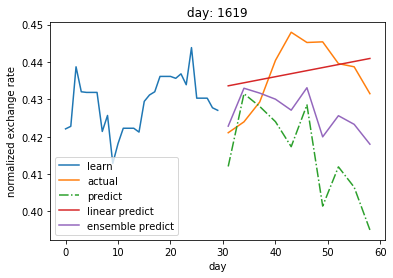

MSE of RNN: 6.683e-04
MSE of Linear Regression: 6.390e-05
MSE of Ensemble: 2.038e-04


In [120]:
import sklearn.linear_model

np.random.seed(0)
for i in np.random.randint(no_hist_days, test_X.shape[0]-31, size=50):
    watch_window = test_X[i,:,:]
    #print(watch_window.shape )
    watch_window = watch_window.reshape( (1,no_hist_days,-1) )
    watch_window_plot = test_X[i,:,0]
    actual = test_y[i,:]
    prediction = best_denoised_model.predict(watch_window)
    prediction = prediction.reshape( (num_pred_days,) )
    
    lin_mod = sklearn.linear_model.LinearRegression()
    lin_mod.fit(np.arange(no_hist_days).reshape(-1, 1), watch_window_plot)
    lin_pred = lin_mod.predict((no_hist_days+pred_days).reshape(-1, 1) )
    
    ensemble_learn = np.mean([prediction, lin_pred], axis=0)
    
    lin_mod_wo_interc = sklearn.linear_model.LinearRegression(fit_intercept=False)
    lin_mod_wo_interc.fit(np.arange(1-no_hist_days,1,+1).reshape(-1, 1), watch_window_plot)
    lin_pred_wo_interc = lin_mod_wo_interc.predict( pred_days.reshape(-1, 1) )   
    
    pyplot.plot(np.arange(no_hist_days), watch_window_plot, label='learn')
    pyplot.plot(no_hist_days+pred_days , actual, label='actual')    #np.arange(last_pred_day)
    pyplot.plot(no_hist_days+pred_days, prediction, '-.', label='predict')
    pyplot.plot(no_hist_days+pred_days, lin_pred, label='linear predict')
    pyplot.plot(no_hist_days+pred_days, ensemble_learn, label='ensemble predict')
    #pyplot.plot(no_hist_days+pred_days, lin_pred_wo_interc, label='linear predict wo intercept')
    pyplot.title('day: %d' % i)
    pyplot.ylabel('normalized exchange rate')
    pyplot.xlabel('day')
    pyplot.legend()
    pyplot.show()

    mse = np.mean(np.square(prediction - actual))
    mse_ens = np.mean(np.square(ensemble_learn - actual))
    mse_lin = np.mean(np.square(lin_pred - actual))
#     scale_factor = 1/scaler.scale_[0]   ## bring back to original scale
#     mse *= scale_factor
    
    print("MSE of RNN: %.3e" % mse)
    print("MSE of Linear Regression: %.3e" % mse_lin)
    print("MSE of Ensemble: %.3e" % mse_ens)







In [ ]:
gru1000  = load_model('denoised_GRU1000.h5')
lstm1000  = load_model('denoised_LSTM1000.h5')




stream_lin = []
stream_ens = []


for i in range(N-no_hist_days-last_pred_day-1):
    
    
    watch_window = lin_test_X[i,:,:]
    #print(watch_window.shape )
    watch_window = watch_window.reshape( (1,no_hist_days,-1) )
    watch_window_plot = lin_test_X[i,:,0]
    actual = test_y[i,:]

    gru1000_prediction = lstm1000.predict(watch_window)
    gru1000_prediction = prediction.reshape( (num_pred_days,) )
    
    lstm1000_prediction = lstm1000.predict(watch_window)
    lstm1000_prediction = prediction.reshape( (num_pred_days,) )
    
    lin_mod = sklearn.linear_model.LinearRegression()
    lin_mod.fit(np.arange(no_hist_days).reshape(-1, 1), watch_window_plot)
    lin_pred = lin_mod.predict((no_hist_days+pred_days).reshape(-1, 1) )
    
    mse_lin = np.mean(np.square(lin_pred - actual))
    mse_ens = np.mean(np.square(ensemble_learn - actual))
    mse_lin = np.mean(np.square(lin_pred - actual))
    
#     scale_factor = 1/scaler.scale_[0] # bring back to original scale
#     mse *= scale_factor
    ## ==================================================
        
    stream.append(mse_lin)
    
            
print("%.3e" % np.mean(stream))